<a href="https://colab.research.google.com/github/arnav39/d2el-en/blob/main/3_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
import torch.nn as nn

In [5]:
import random

In [6]:
import numpy as np

In [7]:
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler

rcParams['figure.figsize'] = 12, 6
rcParams['axes.spines.top'] = True
rcParams['axes.spines.right'] = True
rcParams['lines.linewidth'] = 2.5
rcParams['axes.prop_cycle'] = cycler(color = ['#424242'])
rcParams['xtick.labelsize'] = 'xx-large'
rcParams['ytick.labelsize'] = 'xx-large'

In [5]:
def add_to_class(Class):
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

In [ ]:
a = torch.randn(1000, 5)
b = torch.arange(10)
c = a[b]
print(c)

tensor([[ 2.0115e+00,  1.0490e+00,  2.1183e+00,  7.6310e-01,  1.2847e+00],
        [ 5.8826e-02, -7.5226e-01,  1.2289e+00,  1.1041e+00, -1.2470e+00],
        [-9.3430e-01,  1.7575e-01,  2.8073e-01, -2.9453e-01, -1.5801e-01],
        [-9.5380e-01, -7.2422e-01,  2.4240e+00, -9.8855e-02,  7.9083e-02],
        [-1.9233e-01,  6.5551e-01, -1.7140e-01, -6.7821e-01,  3.2843e+00],
        [-1.4092e+00, -5.3080e-01, -3.9883e-01,  1.9136e-03, -1.3511e+00],
        [ 5.3173e-01,  8.1746e-01,  2.6473e+00, -4.5807e-01, -3.3929e-01],
        [-7.8014e-01, -1.6398e+00,  3.2639e-02,  1.0598e+00,  6.0670e-01],
        [ 2.2797e-01, -2.0867e+00, -1.1192e+00,  3.1195e-01,  5.1415e-01],
        [ 2.6153e+00,  2.1628e-01, -1.1127e+00,  4.8270e-01,  8.0973e-02]])


In [ ]:
l = [1, 2, 3, 4]
l[3:7] # doesn't give an error when we access out of range index

[4]

In [6]:
class Data():

  def __init__(self, n_train, n_val, n_features, batch_size):
    self.n_train = n_train # number of training examples
    self.n_val = n_val # number of validation examples
    self.n_features = n_features # number of features/ input size
    self.batch_size = batch_size
    n = n_train + n_val
    self.X = torch.randn(n, n_features)
    noise = torch.normal(0, 0.01, (n, 1)) * 0.01
    w = torch.ones(n_features, 1) * 0.01
    b = torch.tensor([0.05], dtype=torch.float32)
    self.y = torch.mm(self.X, w) + b + noise

  def get_dataloader(self, train):
    # train takes true or false
    if train:
      indices = list(range(0, self.n_train))
      random.shuffle(indices)

    else:
      indices = list(range(self.n_train, self.n_train + self.n_val))

    for i in range(0, len(indices), self.batch_size):
      batch_indices = torch.tensor(indices[i: i + self.batch_size])
      yield self.X[batch_indices], self.y[batch_indices]

In [ ]:
data = Data(1000, 500, 5, 300).get_dataloader(train=False)

In [ ]:
for X, y in data:
  print(f"X.shape = {X.shape}, y.shape = {y.shape}")

X.shape = torch.Size([300, 5]), y.shape = torch.Size([300, 1])
X.shape = torch.Size([200, 5]), y.shape = torch.Size([200, 1])


In [ ]:
a = next(data)

In [ ]:
a[0].shape

torch.Size([250, 5])

In [ ]:
a[1].shape

torch.Size([250, 1])

In [13]:
def l2_penalty(w):
  p = (w ** 2).sum() / 2
  return p

In [7]:
class WeightDecayScratch():

  def __init__(self, input_size, output_size, lambd, lr=0.01):
    self.input_size = input_size
    self.output_size = output_size
    self.lambd = lambd
    self.w = torch.normal(0, 0.01, (input_size, 1), requires_grad=True)
    self.b = torch.zeros(1, requires_grad=True)
    self.lr = lr # learning rate

  def forward(self, X):
    y_hat = torch.mm(X, self.w) + self.b
    return y_hat

  def loss(self, y, y_hat):
    crit = nn.MSELoss()
    l1 = crit(y, y_hat)
    l2 = l2_penalty(self.w) * self.lambd
    return (l1+l2)

In [ ]:
a = torch.randn(5, requires_grad=True)
b = (2 * a).sum()

with torch.no_grad():
  b = 4 * b
  b.backward()

RuntimeError: ignored

In [20]:
class Trainer():

  def __init__(self, max_epochs):
    self.max_epochs = max_epochs
    self.training_loss = [] # has the training loss at the end of each epoch
    self.val_loss = [] # has the validation loss at the end of each epoch

  def fit(self, model, data):
    # data is a generator object

    optimizer = torch.optim.SGD([model.w, model.b], model.lr)

    for epoch in range(self.max_epochs):

      # training_loop : 

      t_loss = torch.zeros(1) # stores the loss for the current epoch
      train_data = data.get_dataloader(train=True) # just give me the training dataset

      for X, y in train_data:
        # forward_pass : y_hat and loss
        y_hat = model.forward(X)
        l = model.loss(y, y_hat)
        t_loss += l

        # backward pass
        l.backward()

        # update the prarms
        optimizer.step()

        # empty the grad
        optimizer.zero_grad()

      self.training_loss.append(t_loss.item())

      # validation loop:
      t_loss = torch.zeros(1)
      val_data = data.get_dataloader(train=False)

      with torch.no_grad():
        for X, y in val_data:
          y_hat = model.forward(X)
          l = model.loss(y, y_hat)
          t_loss += l
      
      self.val_loss.append(t_loss.item())

In [21]:
@add_to_class(Trainer)
def Plot(self):
  epochs = list(range(self.max_epochs))
  # print(f"len of epochs = {len(epochs)}")
  # print(f"len of train_loss = {len(self.training_loss)}")
  # print(f"len of valid_loss = {len(self.val_loss)}")

  plt.plot(epochs, self.training_loss, color = 'blue', linestyle='solid',label = "train_loss")
  plt.plot(epochs, self.val_loss, color = 'orange', linestyle='dashed', label='val_loss')
  plt.legend()
  plt.grid()
  plt.xlabel("epochs")
  plt.ylabel("Loss")
  plt.show()

In [ ]:
l = [1, 2, 3, 4]

In [ ]:
len(l)

4

now the classes are ready time to implement

In [10]:
data = Data(n_train=20, n_val=100, n_features=200, batch_size=5)

In [22]:
def train_scratch(lambd):
  trainer = Trainer(max_epochs=10)
  model = WeightDecayScratch(200, 1, lambd)
  trainer.fit(model, data)
  print(f"L2 Norm of w = {l2_penalty(model.w)}")
  trainer.Plot()

L2 Norm of w = 0.008858496323227882


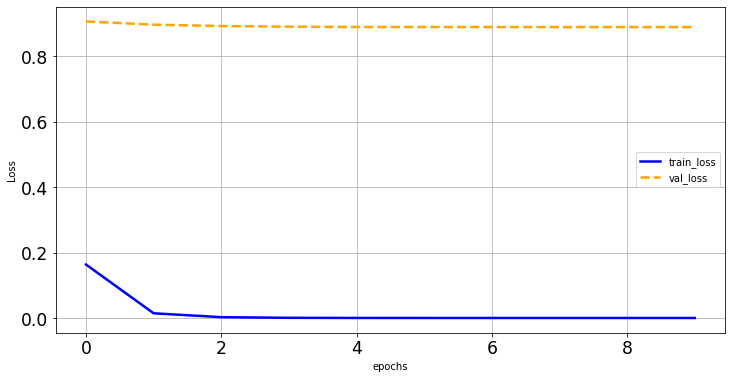

In [23]:
train_scratch(0) # without weight decay

# PROUD MOMENT : RAN WITHOUT ERROR IN THE FIRST ATTEMPT

too much overfitting

L2 Norm of w = 0.0014972068602219224


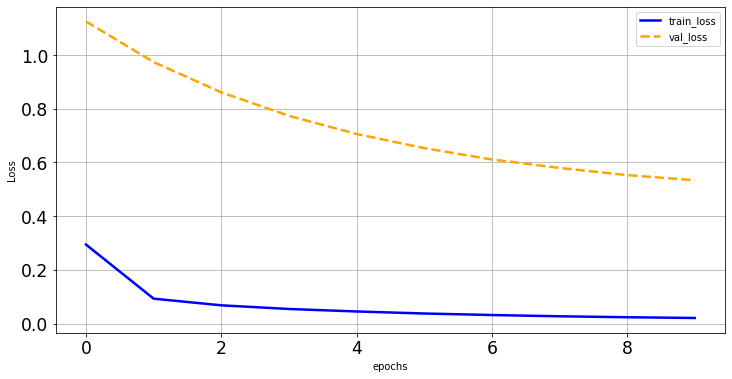

In [24]:
train_scratch(3)

L2 Norm of w = 0.0005779908387921751


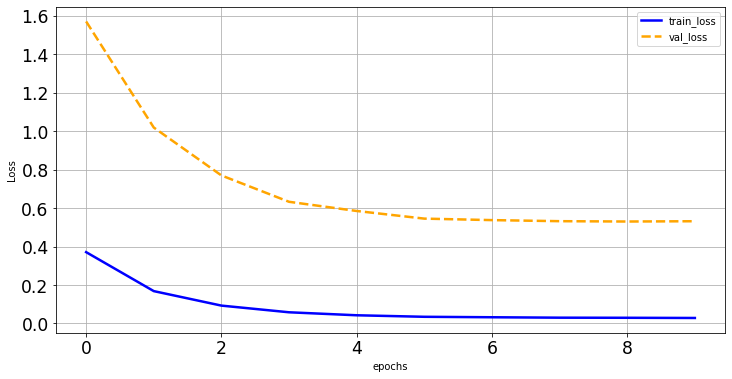

In [25]:
train_scratch(9)

L2 Norm of w = 0.00023870171571616083


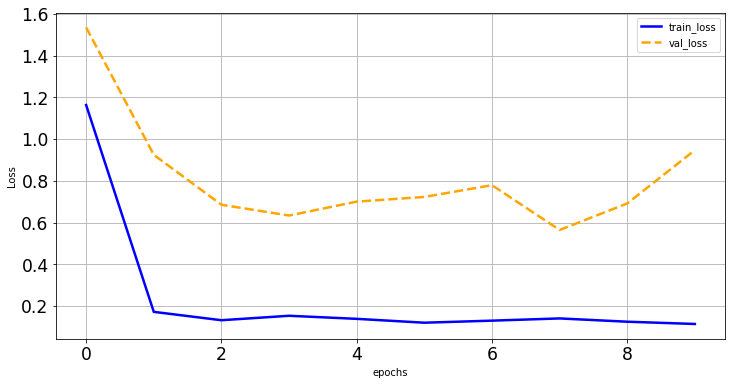

In [26]:
train_scratch(100)

## Concise Implementation

In [1]:
def give_data(n_samples, w, b, noise=0.01):

  X = torch.randn(n_samples, len(w))
  noise = torch.randn(n_samples, 1) * noise
  y = torch.mm(X, w) + b + noise
  return X, y

In [2]:
class WeightDecay():
  
  def __init__(self, input_size, output_size, wd, lr=0.01):
    # wd is the weight decay
    self.input_size = input_size
    self.output_size = output_size
    self.wd = wd
    self.lr = lr
    self.lin = nn.Linear(input_size, output_size)

  def configure_optimizers(self):
    optim = torch.optim.SGD(self.lin.parameters(), self.lr, weight_decay=self.wd)
    return optim

  def loss(self, y, y_hat):
    crit = nn.MSELoss()
    l1 = crit(y, y_hat)

    w = next(self.lin.parameters()).data
    l2 = ((w ** 2).sum() / 2) * self.wd
    return (l1+l2)

In [8]:
w = torch.tensor([-5.6, 1.3, 6.7], dtype=torch.float32, requires_grad=True).reshape(-1, 1)
b = torch.tensor([-7.7], dtype=torch.float32, requires_grad=True)

X, y = give_data(1500, w, b)
X_train, X_test = X[0:1000, :], X[1000:1500, :]
print(f"X_train.shape = {X_train.shape}, X_test.shape = {X_test.shape}")
y_train, y_test = y[0:1000, :], y[1000:1500, :]
print(f"y_train.shape = {y_train.shape}, y_test.shape = {y_test.shape}")

X_train.shape = torch.Size([1000, 3]), X_test.shape = torch.Size([500, 3])
y_train.shape = torch.Size([1000, 1]), y_test.shape = torch.Size([500, 1])


In [ ]:
max_epochs=1000
wd = 4
train_loss = []
val_loss = []

inst = WeightDecay(X.shape[1], y.shape[1], wd)
linear = inst.lin
optim = inst.configure_optimizers()

for epoch in range(max_epochs):

  # forward_pass: 
  y_hat = linear(X_train)
  l = inst.loss(y_train, y_hat)

  # backward pass:
  l.backward()

  # update the params:
  optim.step()

  # zero the grad:
  optim.zero_grad()

  with torch.no_grad():
    train_loss.append(l.item())
    y_hat = linear(X_test)
    l = inst.loss(y_test, y_hat)
    val_loss.append(l.item())

In [33]:
a = nn.parameter.Parameter(data=torch.ones(5, 1), requires_grad=True)
print(a)

Parameter containing:
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], requires_grad=True)


In [37]:
print(a.data)
b = a.data.reshape(len(a.data))
print(f"square of norm of a = {torch.dot(b, b)}")

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])
square of norm of a = 5.0
